# Your name:
Sameer Khurana (skhurana)

# Part 2: MNIST: First Principles

In this notebook, we will recreate the functions that PyTorch provides for the individual layers in our network using primtive Python code. The goal of this notebook is to understand what happens in a network underneath the hood.

In [75]:
import math
import torch
import torchvision
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

Import MNIST test data as numpy array.

In [2]:
# download test set using torchvision
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5,), (0.5,))])

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=1)

# convert to numpy array
images_array = torch.zeros((10000,28,28))
labels_array = torch.zeros(10000)
for i, data in enumerate(testloader, 0):
    image, label = data
    images_array[i,:,:] = image
    labels_array[i] = label
images_array = images_array.numpy()
labels_array = labels_array.numpy()
labels_array = labels_array.astype(int)
print(images_array.shape)

(10000, 28, 28)


## Load the trained model parameters

### Question 9.

Visualize the first test image and label.

Load the model parameters (the file you saved in pytorch.ipynb). Similarly visualize the weights of the filters used in the first convolutional layer.

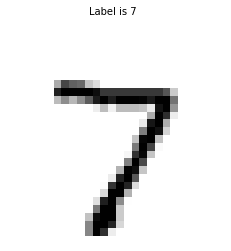

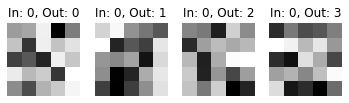

In [23]:
# Make sure you have saved model_parameters.npy
model_parameters = np.load('my_model_parameters.npy', allow_pickle=True)
model_parameters = model_parameters[()]

plt.figure(1)
# Your code to display one input image here (with its label)
plt.imshow(-1*images_array[0], cmap='gray')
plt.text(10, -2, "Label is " + str(labels_array[0]))
plt.axis('off')
l1_filter = model_parameters['l0_w'] # update
num_input_channels = l1_filter.shape[1]
num_out_channels = l1_filter.shape[0] # filters
plt.figure(2)
for x in range(num_out_channels): # filters
    for y in range(num_input_channels): # channels
        plt.subplot(num_input_channels, num_out_channels, y*num_out_channels + x + 1)
        # Your code for the filter here
        plt.imshow(-1*l1_filter[x, y], cmap="gray")
        plt.title("In: %d, Out: %d" % (y, x))
        plt.axis('off')


## Set up the network

### Question 10.

We need to write code to run the individual layers in our network. For simiplicity, assume that the batch size is 1, i.e., the activation layers are numpy arrays with shape (channels, height, width).

In [365]:
def conv(x, F, b, U=1, padding=2):
    C, H, W = x.shape
    M, C, R, S = F.shape
    P = (H - R + 2*padding + U) / U
    Q = (W - S + 2*padding + U) / U
    P = math.floor(P)
    Q = math.floor(Q)
    x = np.pad(x, pad_width=((0, 0), (2, 2), (2, 2)))
    O = np.zeros((M, P, Q))
    for m in range(M):
        for p in range(P):
            for q in range(Q):
                for c in range(C):
                    for r in range(R):
                        for s in range(S):
                            O[m][p][q] += (x[c][U*p+r][U*q+s] * F[m][c][r][s])
    
    return O + b[:, None, None]

def fc(x, W, b):
    out = W@x + b
    return out

def relu(x):
    out = np.maximum(x, 0)
    return out

def pool2(x, dh, dw, U=2, padding=0):
    C, H, W = x.shape
    P = (H - dh + 2*padding + U) / U
    Q = (W - dw + 2*padding + U) / U
    P = math.floor(P)
    Q = math.floor(Q)
    O = np.zeros((C, P, Q))
    for p in range(P):
        for q in range(Q):
            for c in range(C):
                for r in range(dh):
                    for s in range(dw):
                        val = x[c][U*p+r][U*q+s]
                        if O[c, p, q] < val:
                            O[c, p, q] = val
    return O

def flatten(x):
    # Your code here
    return x.flatten()

### Question 11.

Compose the layers from above to create the network from `mnist/pytorch.py`

In [400]:
def run_inference(image, model_parameters):
    # Your code for defining the correct network topology here, using the saved model parameters
    # replace code below
    conv1_w = model_parameters['l0_w']
    conv1_b = model_parameters['l0_b']
    conv2_w = model_parameters['l3_w']
    conv2_b = model_parameters['l3_b']
    fc1_w = model_parameters['l6_w']
    fc1_b = model_parameters['l6_b']
    fc2_w = model_parameters['l8_w']
    fc2_b = model_parameters['l8_b']
    x = conv(image, conv1_w, conv1_b)
    x = relu(x)
    x = pool2(x, 2, 2)
    x = conv(x, conv2_w, conv2_b)
    x = relu(x)
    x = pool2(x, 2, 2)
    x = x.flatten()
    x = fc(x, fc1_w, fc1_b)
    x = relu(x)
    x = fc(x, fc2_w, fc2_b)
    output_class = np.argmax(x) # calculate output label here
    return output_class

Run the cell below to verify your network on the first 1000 images from the test dataset

In [404]:
correct, total = (0, 1000)
for n in tqdm(range(min(total, int(images_array.shape[0])))):
    inference = run_inference(images_array[n][None, ...], model_parameters)
    if labels_array[n] == inference:
        correct += 1
print("Accuracy: %d/%d (%.2g)" % (correct, total, float(correct)/total))

100%|██████████| 1000/1000 [47:15<00:00,  2.84s/it]

Accuracy: 950/1000 (0.95)


### Question 12.
You have built a programmable system that performs classification on MNIST, where the input image size is 28x28 @ 95% accuracy. It only spends 0.1nJ per classification and operates at 100 classifications per second. You then use it to perform classification on ImageNet, where the input image size is 224x224 @ 95% accuracy. However, you noticed that the energy and latency scale much more than 224x224/(28x28). What could be causing the non-linear scaling? Answer in the cell below.


-your-answer-here-

